# Assignment 5: Deep Learning with CIFAR-10 (PyTorch Version)

* By: Mohamed-Obay Alshaer
* Course: SEG4300 - Applied Machine Learning
* Student number: 300170489

## Introduction

In this assignment, we will train a deep learning model using PyTorch on the CIFAR-10 dataset from the Hugging Face Datasets Library. We'll go through the complete machine learning pipeline including dataset selection, preprocessing, model development, training, and evaluation.

## Setup and Dependencies

First, let's install and import the necessary libraries:

In [1]:
# Install required packages
!pip install datasets torch torchvision numpy matplotlib seaborn scikit-learn pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.5 MB/s eta 0:00:00a 0:00:01


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.notebook import tqdm
import time
import warnings
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Ignore warnings
warnings.filterwarnings('ignore')

# Check for available device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")
print(f"Using device: {device}")
print(f"PyTorch Version: {torch.__version__}")

Using device: mps
PyTorch Version: 2.2.2


## 1. Dataset Selection

### Why CIFAR-10?

For this assignment, I've chosen the **CIFAR-10 dataset** from the Hugging Face Datasets Library. This dataset is ideal for deep learning image classification tasks for several reasons:

1. **Well-established benchmark**: CIFAR-10 is a widely used dataset in computer vision research, making it perfect for demonstrating deep learning concepts.

2. **Manageable complexity**: With 60,000 32x32 color images across 10 classes, it's complex enough to require a deep learning approach but not so large that it demands excessive computational resources.

3. **Balanced data**: The dataset contains an equal number of images per class (6,000), eliminating concerns about class imbalance.

4. **Diversity of objects**: The 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck) represent a good variety of real-world objects with different shapes, textures, and contexts.

5. **Appropriate for CNNs**: The small, consistent image size (32x32) makes it well-suited for convolutional neural networks without requiring extensive preprocessing or resizing.

6. **Challenging enough**: Unlike simpler datasets like MNIST, CIFAR-10 presents a meaningful challenge for deep learning models due to the complexity of natural images and the relatively small image size.

### Dataset Details

- **Size**: 60,000 color images (32x32 pixels)
- **Classes**: 10 categories (6,000 images per class)
- **Splits**: 50,000 training images and 10,000 test images
- **Features**: RGB images represented as 32x32x3 arrays
- **Labels**: Integer values from 0 to 9 corresponding to the different classes

Now let's load the dataset and explore its properties:

In [3]:
# Load the CIFAR-10 dataset from Hugging Face
dataset = load_dataset("uoft-cs/cifar10")
print(dataset)

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})


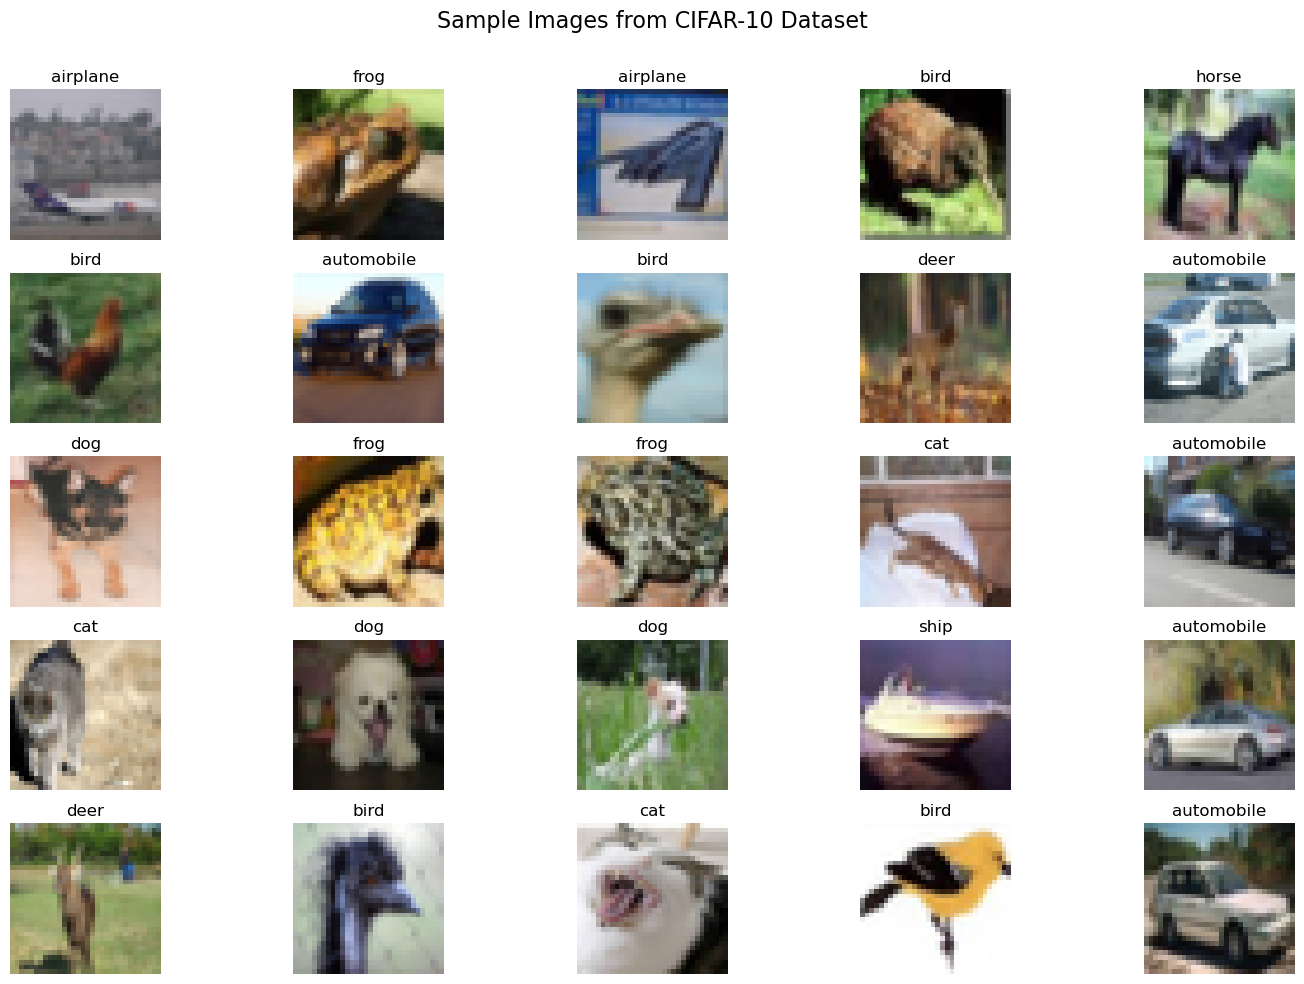

In [4]:
# Define class names for reference
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Display a few sample images from the training set
plt.figure(figsize=(15, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    img = dataset['train'][i]['img']
    label = dataset['train'][i]['label']
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Sample Images from CIFAR-10 Dataset", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

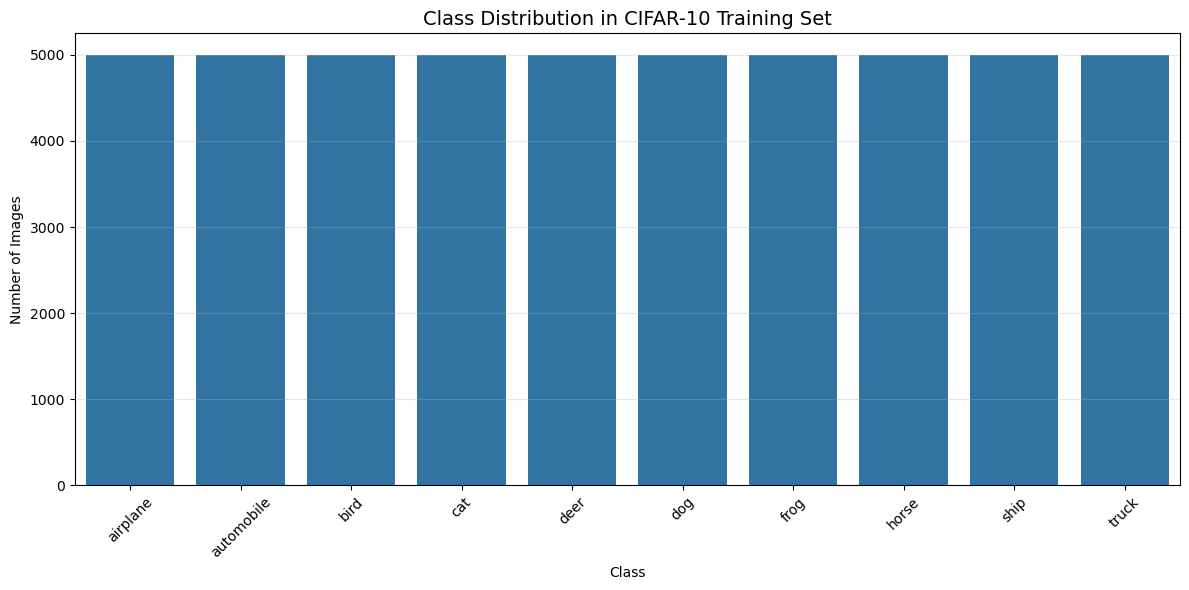

In [5]:
# Analyze the class distribution in the training set
train_labels = [sample['label'] for sample in dataset['train']]
label_counts = {}
for label in train_labels:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Visualize the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_names), y=list(label_counts.values()))
plt.title('Class Distribution in CIFAR-10 Training Set', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

For deep learning models, we need to preprocess the image data. The key preprocessing steps include:

1. **Converting PIL images to NumPy arrays**: The dataset provides images in PIL format, which need to be converted to tensors for PyTorch.
2. **Normalizing pixel values**: Scale pixel values from [0, 255] to [0, 1] to improve training stability and convergence.
3. **Creating training and validation splits**: Split the training data to have a validation set for monitoring model performance during training.

Let's implement these preprocessing steps:

In [10]:
# Function to convert dataset to numpy arrays and normalize
def preprocess_dataset(dataset_split):
    images = []
    labels = []
    print(f"Processing {len(dataset_split)} images...")
    
    # Use a batch approach for efficiency
    batch_size = 1000
    num_batches = len(dataset_split) // batch_size + (1 if len(dataset_split) % batch_size != 0 else 0)
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(dataset_split))
        
        batch = [dataset_split[i] for i in range(start_idx, end_idx)]
        batch_images = [np.array(sample['img']) for sample in batch]
        batch_labels = [sample['label'] for sample in batch]
        
        images.extend(batch_images)
        labels.extend(batch_labels)
        
        # Print progress
        if (i+1) % max(1, num_batches//10) == 0 or i+1 == num_batches:
            print(f"Processed batch {i+1}/{num_batches}")
    
    # Convert to numpy arrays
    X = np.array(images, dtype=np.float32)
    y = np.array(labels, dtype=np.int64)  # PyTorch uses 64-bit integers for labels
    
    # Normalize pixel values to [0, 1]
    X = X / 255.0
    
    return X, y

In [11]:
# Preprocess training and test sets
print("Preprocessing training set...")
X_train_full, y_train_full = preprocess_dataset(dataset['train'])

print("\nPreprocessing test set...")
X_test, y_test = preprocess_dataset(dataset['test'])

# Split training set to create a validation set (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# Print shapes to verify
print(f"\nTraining set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


Preprocessing training set...
Processing 50000 images...
Processed batch 5/50
Processed batch 10/50
Processed batch 15/50
Processed batch 20/50
Processed batch 25/50
Processed batch 30/50
Processed batch 35/50
Processed batch 40/50
Processed batch 45/50
Processed batch 50/50

Preprocessing test set...
Processing 10000 images...
Processed batch 1/10
Processed batch 2/10
Processed batch 3/10
Processed batch 4/10
Processed batch 5/10
Processed batch 6/10
Processed batch 7/10
Processed batch 8/10
Processed batch 9/10
Processed batch 10/10

Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [12]:
# Convert numpy arrays to PyTorch tensors and reshape for PyTorch (N, C, H, W)
# PyTorch expects channels first format: (batch_size, channels, height, width)

# First, reshape the numpy arrays to move channels dimension to position 1
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_val = np.transpose(X_val, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

# Now convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_val_tensor shape: {X_val_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")

X_train_tensor shape: torch.Size([40000, 3, 32, 32])
X_val_tensor shape: torch.Size([10000, 3, 32, 32])
X_test_tensor shape: torch.Size([10000, 3, 32, 32])


Min pixel value in training set: 0.0
Max pixel value in training set: 1.0


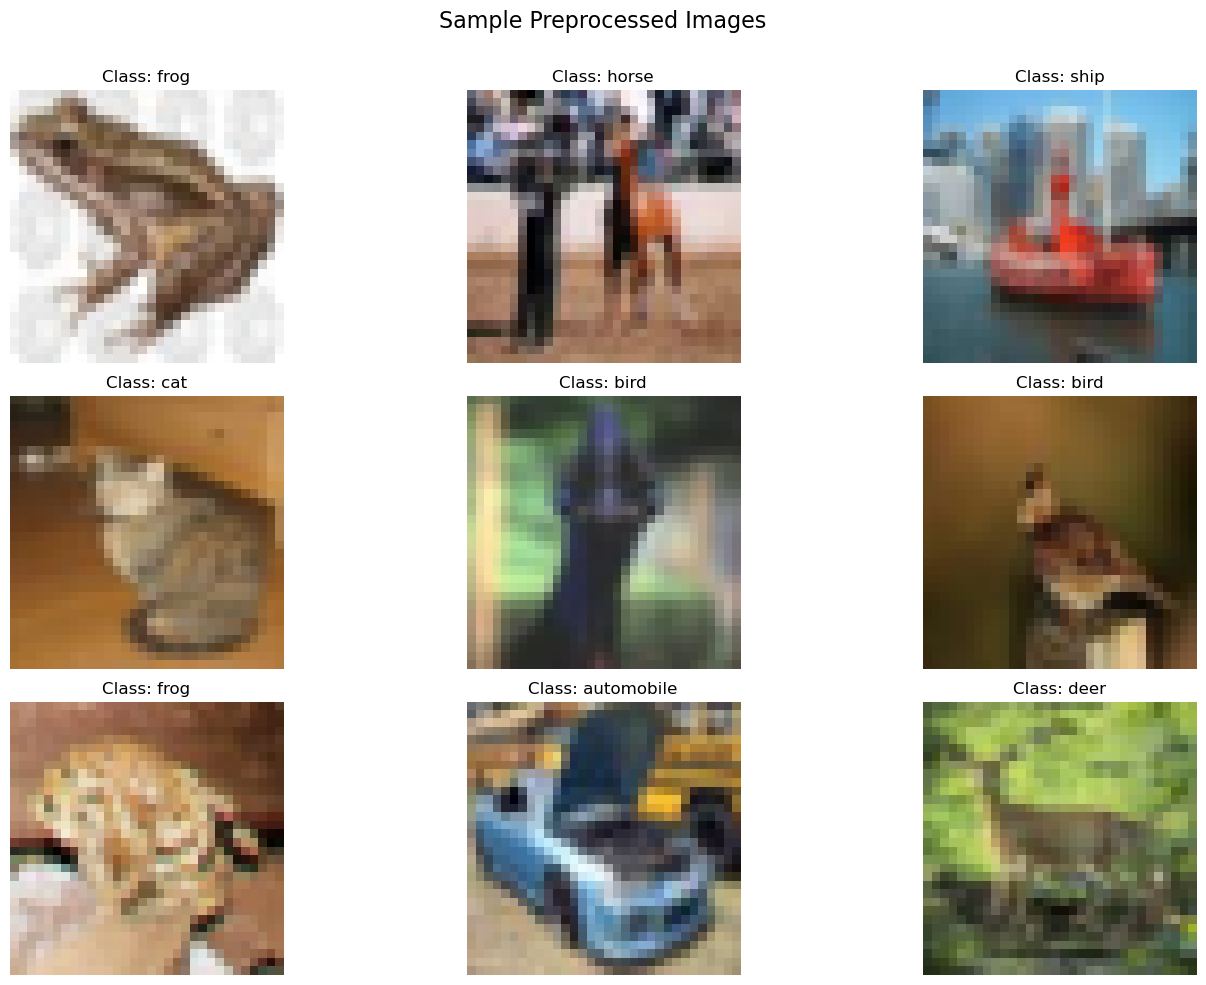

In [13]:
# Check the range of pixel values after normalization
print(f"Min pixel value in training set: {X_train_tensor.min().item()}")
print(f"Max pixel value in training set: {X_train_tensor.max().item()}")

# Display a sample of preprocessed images (we'll need to transpose back for visualization)
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    # Convert tensor to numpy and transpose back to (H, W, C) for plotting
    img = X_train_tensor[i].numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.title(f"Class: {class_names[y_train[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Sample Preprocessed Images", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

## 3. Create PyTorch Datasets and DataLoaders

Now, let's create PyTorch Datasets and DataLoaders for efficient data batching and processing during training:

In [14]:
# Create PyTorch Datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 625
Number of validation batches: 157
Number of test batches: 157


## 4. Data Augmentation

Let's define a class for data augmentation to improve model generalization. PyTorch's data augmentation is applied during training:

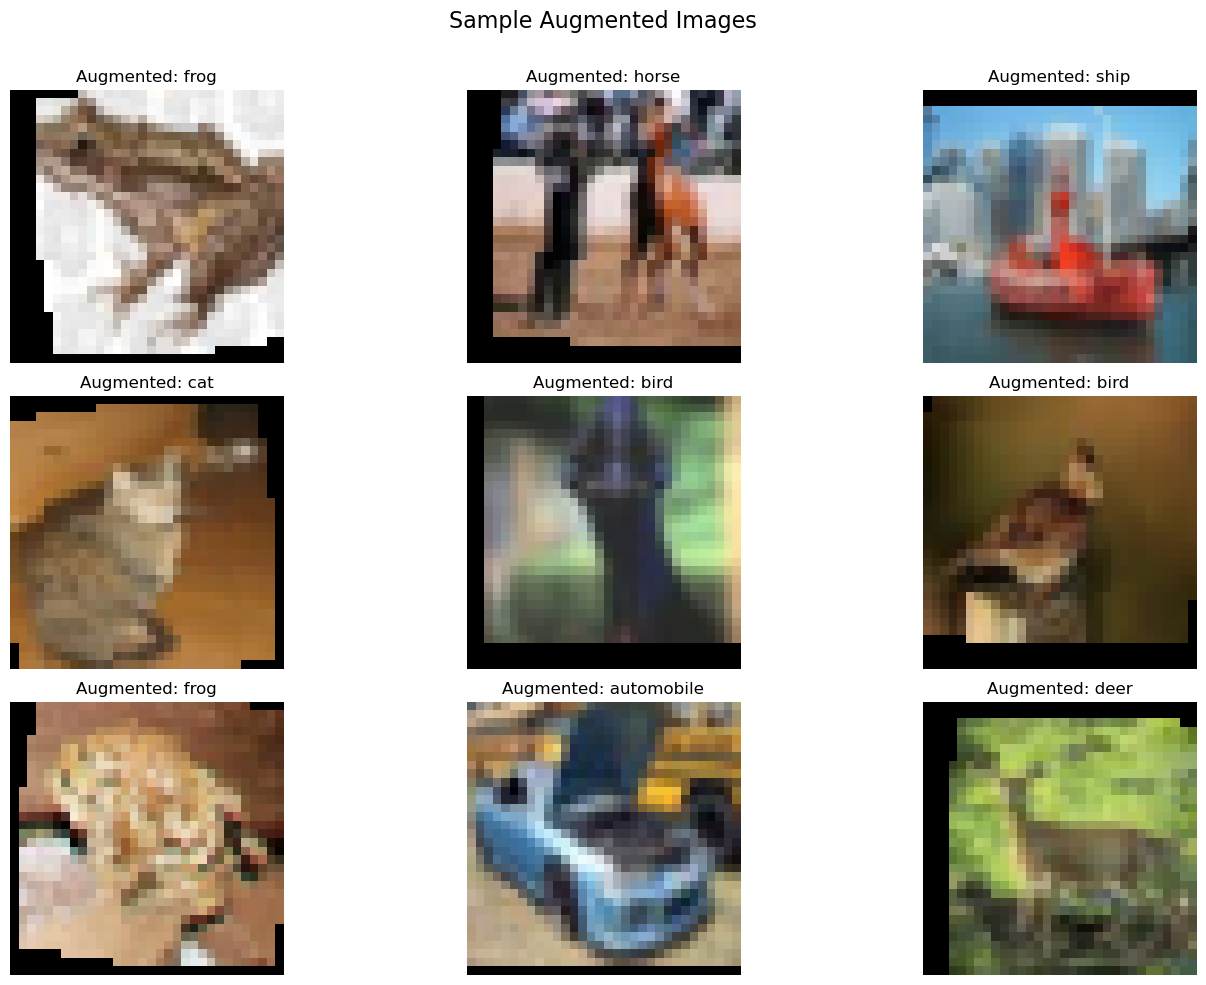

In [15]:
# Define data augmentation transforms
class DataAugmentation:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        ])
        
    def __call__(self, x):
        return self.transforms(x)

# Create the augmentation object
data_augmentation = DataAugmentation()

# Let's visualize some augmented images
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img_tensor = X_train_tensor[i].unsqueeze(0)  # Add batch dimension
    augmented_img = data_augmentation(img_tensor)[0]  # Remove batch dimension
    img = augmented_img.numpy().transpose(1, 2, 0)  # Convert to (H, W, C) for plotting
    plt.imshow(img)
    plt.title(f"Augmented: {class_names[y_train[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Sample Augmented Images", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

## 5. Model Selection and Architecture

For the CIFAR-10 image classification task, we'll use a Convolutional Neural Network (CNN) architecture, which is well-suited for image data. CNNs are designed to automatically learn spatial hierarchies of features from input images through specialized convolutional layers.

### Why CNNs for Image Classification?

1. **Local connectivity**: Convolutional layers focus on local patterns, which is ideal for image data where nearby pixels are more related than distant ones.
2. **Parameter sharing**: The same filters are applied across the entire image, reducing the number of parameters and making the model more efficient.
3. **Spatial hierarchies**: Deep CNNs learn hierarchical representations, from simple edges and textures in early layers to complex object parts in deeper layers.
4. **Translation invariance**: Through pooling operations, CNNs become less sensitive to the exact position of features in the input image.

Let's build a CNN model with the following architecture in PyTorch:
- Convolutional layers with increasing filters (32, 64, 128)
- MaxPooling layers to reduce spatial dimensions
- Batch Normalization for training stability
- Dropout for regularization
- Linear (Dense) layers for classification

In [16]:
# Define the CNN model
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(0.2)
        
        # Second Convolutional Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(0.3)
        
        # Third Convolutional Block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout2d(0.4)
        
        # Calculate the size after convolutional layers
        # Input: 32x32x3
        # After 3 pooling layers (divide by 2^3): 4x4x128
        self.fc1 = nn.Linear(4 * 4 * 128, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

# Create the model and move to device
model = CIFAR10CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)

CIFAR10CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1),

## 6. Training Functions

Let's define functions for training and validation:

In [17]:
# Function to train for one epoch
def train_epoch(model, dataloader, criterion, optimizer, device, data_augmentation=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(dataloader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Apply data augmentation if provided
        if data_augmentation is not None:
            inputs = data_augmentation(inputs)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Function to validate the model
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Validation"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Update statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

## 7. Learning Rate Scheduler and Early Stopping

Let's define a learning rate scheduler to reduce the learning rate when validation loss plateaus, and an early stopping mechanism to prevent overfitting:

In [18]:
# Create a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True
)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_state = None
    
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict().copy()
            return False
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                return True
            return False

# Initialize early stopping
early_stopping = EarlyStopping(patience=10)

## 8. Training Loop

Now, let's train the model:

In [19]:
# Training loop
max_epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("Starting model training...")
start_time = time.time()

for epoch in range(max_epochs):
    print(f"\nEpoch {epoch+1}/{max_epochs}")
    
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, data_augmentation)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Print progress
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Check early stopping
    if early_stopping(val_loss, model):
        print("Early stopping triggered")
        # Restore best model
        model.load_state_dict(early_stopping.best_model_state)
        break

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time/60:.2f} minutes.")

Starting model training...

Epoch 1/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.7542, Train Acc: 0.3544, Val Loss: 1.4119, Val Acc: 0.4884

Epoch 2/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.4628, Train Acc: 0.4634, Val Loss: 1.2096, Val Acc: 0.5632

Epoch 3/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.3157, Train Acc: 0.5264, Val Loss: 1.0544, Val Acc: 0.6265

Epoch 4/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2077, Train Acc: 0.5687, Val Loss: 0.9374, Val Acc: 0.6714

Epoch 5/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1466, Train Acc: 0.5925, Val Loss: 0.9325, Val Acc: 0.6617

Epoch 6/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0834, Train Acc: 0.6188, Val Loss: 0.8537, Val Acc: 0.6945

Epoch 7/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0469, Train Acc: 0.6320, Val Loss: 0.8094, Val Acc: 0.7188

Epoch 8/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0094, Train Acc: 0.6508, Val Loss: 0.7408, Val Acc: 0.7421

Epoch 9/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9771, Train Acc: 0.6626, Val Loss: 0.7356, Val Acc: 0.7476

Epoch 10/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9541, Train Acc: 0.6696, Val Loss: 0.6940, Val Acc: 0.7628

Epoch 11/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9291, Train Acc: 0.6747, Val Loss: 0.7107, Val Acc: 0.7501
EarlyStopping counter: 1 out of 10

Epoch 12/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9054, Train Acc: 0.6861, Val Loss: 0.6870, Val Acc: 0.7562

Epoch 13/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8938, Train Acc: 0.6884, Val Loss: 0.6708, Val Acc: 0.7691

Epoch 14/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8710, Train Acc: 0.6986, Val Loss: 0.6365, Val Acc: 0.7787

Epoch 15/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8559, Train Acc: 0.7026, Val Loss: 0.6287, Val Acc: 0.7784

Epoch 16/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8417, Train Acc: 0.7084, Val Loss: 0.6100, Val Acc: 0.7923

Epoch 17/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8282, Train Acc: 0.7128, Val Loss: 0.6065, Val Acc: 0.7884

Epoch 18/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8207, Train Acc: 0.7160, Val Loss: 0.6238, Val Acc: 0.7823
EarlyStopping counter: 1 out of 10

Epoch 19/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8071, Train Acc: 0.7238, Val Loss: 0.6239, Val Acc: 0.7858
EarlyStopping counter: 2 out of 10

Epoch 20/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7965, Train Acc: 0.7245, Val Loss: 0.5650, Val Acc: 0.8051

Epoch 21/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7938, Train Acc: 0.7282, Val Loss: 0.5866, Val Acc: 0.7984
EarlyStopping counter: 1 out of 10

Epoch 22/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7758, Train Acc: 0.7343, Val Loss: 0.5705, Val Acc: 0.8029
EarlyStopping counter: 2 out of 10

Epoch 23/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7696, Train Acc: 0.7346, Val Loss: 0.5356, Val Acc: 0.8176

Epoch 24/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7596, Train Acc: 0.7394, Val Loss: 0.5530, Val Acc: 0.8113
EarlyStopping counter: 1 out of 10

Epoch 25/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7582, Train Acc: 0.7391, Val Loss: 0.5419, Val Acc: 0.8128
EarlyStopping counter: 2 out of 10

Epoch 26/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7486, Train Acc: 0.7439, Val Loss: 0.5642, Val Acc: 0.8058
EarlyStopping counter: 3 out of 10

Epoch 27/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7336, Train Acc: 0.7481, Val Loss: 0.5329, Val Acc: 0.8188

Epoch 28/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7305, Train Acc: 0.7518, Val Loss: 0.5351, Val Acc: 0.8137
EarlyStopping counter: 1 out of 10

Epoch 29/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7204, Train Acc: 0.7545, Val Loss: 0.5180, Val Acc: 0.8219

Epoch 30/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7230, Train Acc: 0.7506, Val Loss: 0.5249, Val Acc: 0.8192
EarlyStopping counter: 1 out of 10

Epoch 31/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7178, Train Acc: 0.7564, Val Loss: 0.5516, Val Acc: 0.8072
EarlyStopping counter: 2 out of 10

Epoch 32/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7087, Train Acc: 0.7562, Val Loss: 0.5116, Val Acc: 0.8230

Epoch 33/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7052, Train Acc: 0.7596, Val Loss: 0.5042, Val Acc: 0.8237

Epoch 34/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7014, Train Acc: 0.7612, Val Loss: 0.5773, Val Acc: 0.8025
EarlyStopping counter: 1 out of 10

Epoch 35/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6949, Train Acc: 0.7635, Val Loss: 0.5031, Val Acc: 0.8238

Epoch 36/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6916, Train Acc: 0.7644, Val Loss: 0.5035, Val Acc: 0.8270
EarlyStopping counter: 1 out of 10

Epoch 37/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6879, Train Acc: 0.7659, Val Loss: 0.5098, Val Acc: 0.8242
EarlyStopping counter: 2 out of 10

Epoch 38/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6857, Train Acc: 0.7679, Val Loss: 0.4880, Val Acc: 0.8324

Epoch 39/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6794, Train Acc: 0.7689, Val Loss: 0.4762, Val Acc: 0.8339

Epoch 40/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6768, Train Acc: 0.7698, Val Loss: 0.4885, Val Acc: 0.8352
EarlyStopping counter: 1 out of 10

Epoch 41/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6729, Train Acc: 0.7714, Val Loss: 0.4979, Val Acc: 0.8273
EarlyStopping counter: 2 out of 10

Epoch 42/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6596, Train Acc: 0.7763, Val Loss: 0.4623, Val Acc: 0.8409

Epoch 43/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6665, Train Acc: 0.7729, Val Loss: 0.4832, Val Acc: 0.8315
EarlyStopping counter: 1 out of 10

Epoch 44/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6631, Train Acc: 0.7744, Val Loss: 0.4608, Val Acc: 0.8433

Epoch 45/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6513, Train Acc: 0.7792, Val Loss: 0.4614, Val Acc: 0.8420
EarlyStopping counter: 1 out of 10

Epoch 46/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6552, Train Acc: 0.7751, Val Loss: 0.4572, Val Acc: 0.8454

Epoch 47/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6466, Train Acc: 0.7799, Val Loss: 0.4659, Val Acc: 0.8392
EarlyStopping counter: 1 out of 10

Epoch 48/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6460, Train Acc: 0.7802, Val Loss: 0.4630, Val Acc: 0.8396
EarlyStopping counter: 2 out of 10

Epoch 49/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6460, Train Acc: 0.7818, Val Loss: 0.4584, Val Acc: 0.8451
EarlyStopping counter: 3 out of 10

Epoch 50/50


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6412, Train Acc: 0.7810, Val Loss: 0.4832, Val Acc: 0.8320
EarlyStopping counter: 4 out of 10

Training completed in 29.44 minutes.


## 9. Model Evaluation

Let's evaluate our model on the test set and visualize its performance:

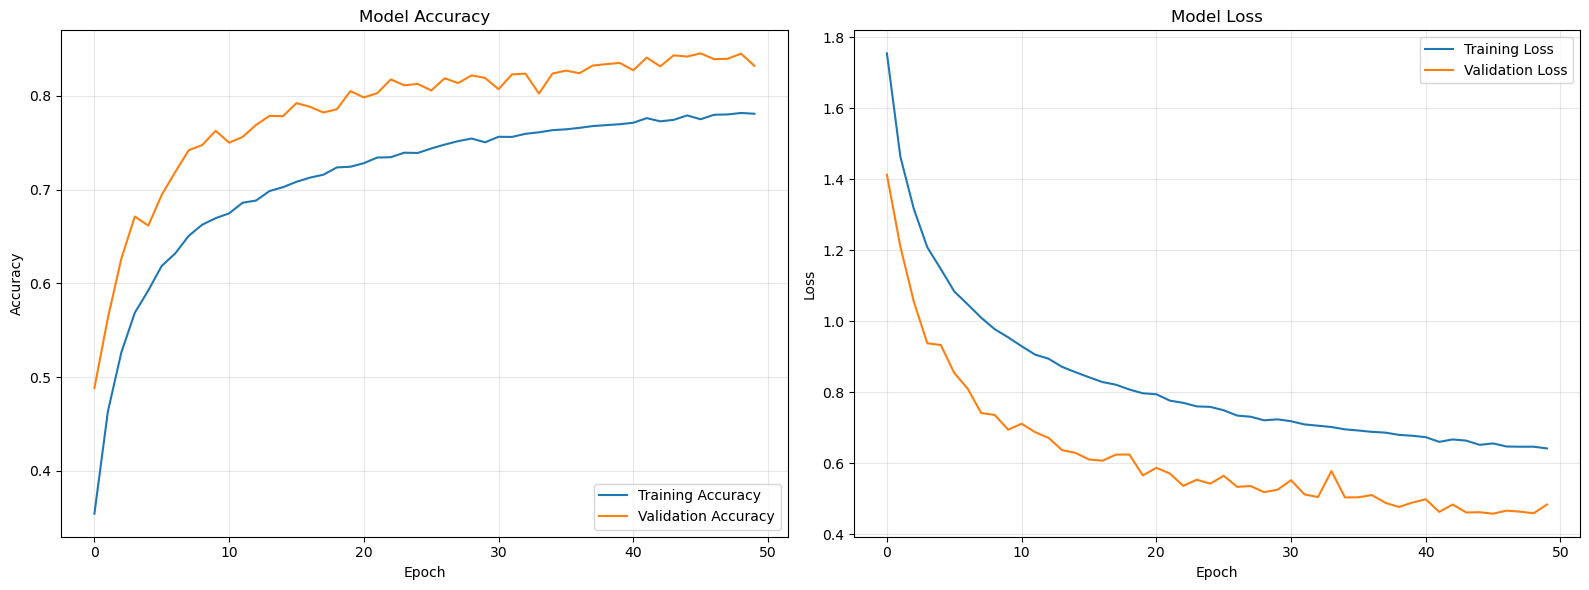

In [20]:
# Plot training history
plt.figure(figsize=(16, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.4892
Test Accuracy: 0.8303


In [22]:
# Generate predictions and ground truth for detailed analysis
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Generating predictions"):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

Generating predictions:   0%|          | 0/157 [00:00<?, ?it/s]

In [23]:
# Generate classification report
print("Classification Report:")
report = classification_report(all_targets, all_preds, target_names=class_names, digits=4)
print(report)

Classification Report:
              precision    recall  f1-score   support

    airplane     0.8504    0.8240    0.8370      1000
  automobile     0.9159    0.9470    0.9312      1000
        bird     0.8392    0.6890    0.7567      1000
         cat     0.7522    0.5890    0.6607      1000
        deer     0.8534    0.7800    0.8150      1000
         dog     0.6677    0.8400    0.7440      1000
        frog     0.8882    0.8660    0.8770      1000
       horse     0.8095    0.9050    0.8546      1000
        ship     0.8840    0.9300    0.9064      1000
       truck     0.8671    0.9330    0.8988      1000

    accuracy                         0.8303     10000
   macro avg     0.8328    0.8303    0.8281     10000
weighted avg     0.8328    0.8303    0.8281     10000



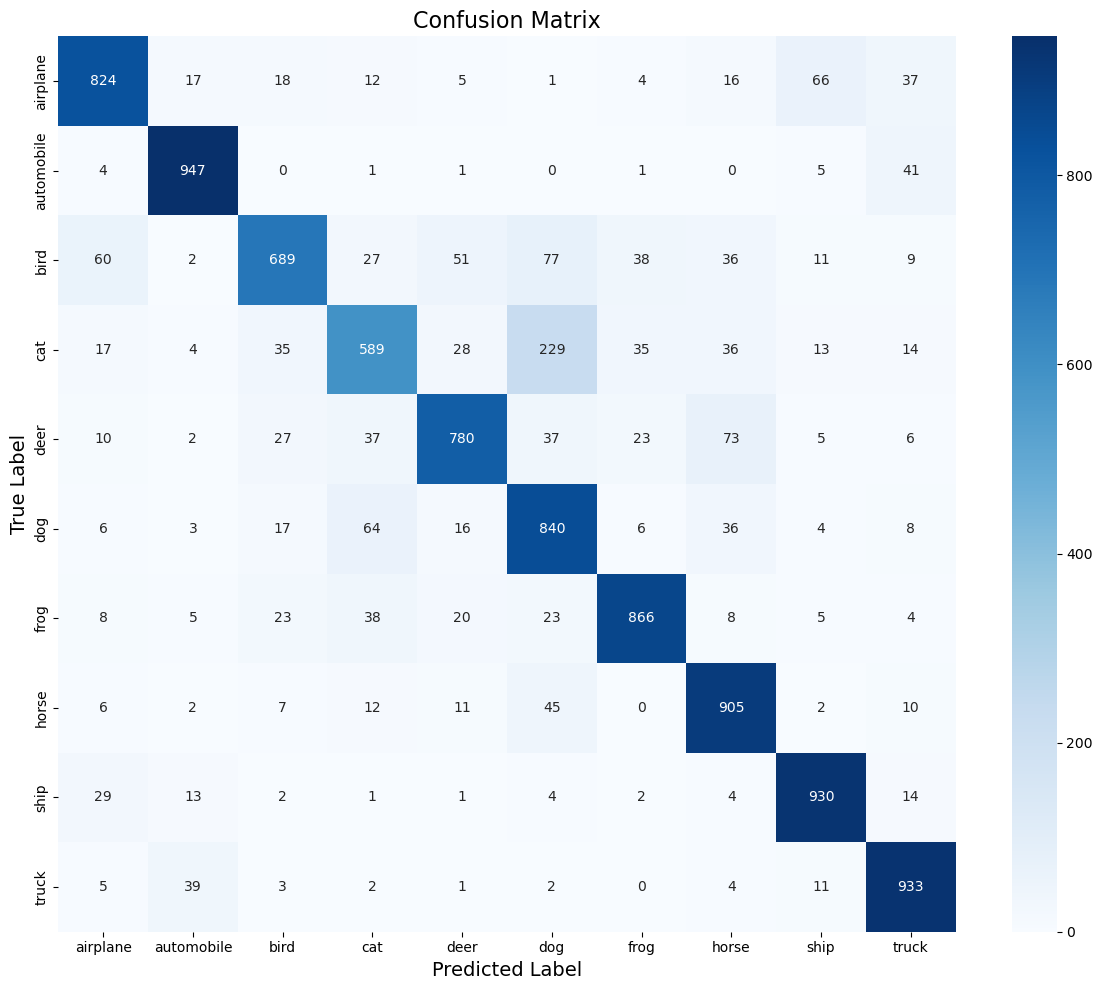

In [24]:
# Generate and visualize confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

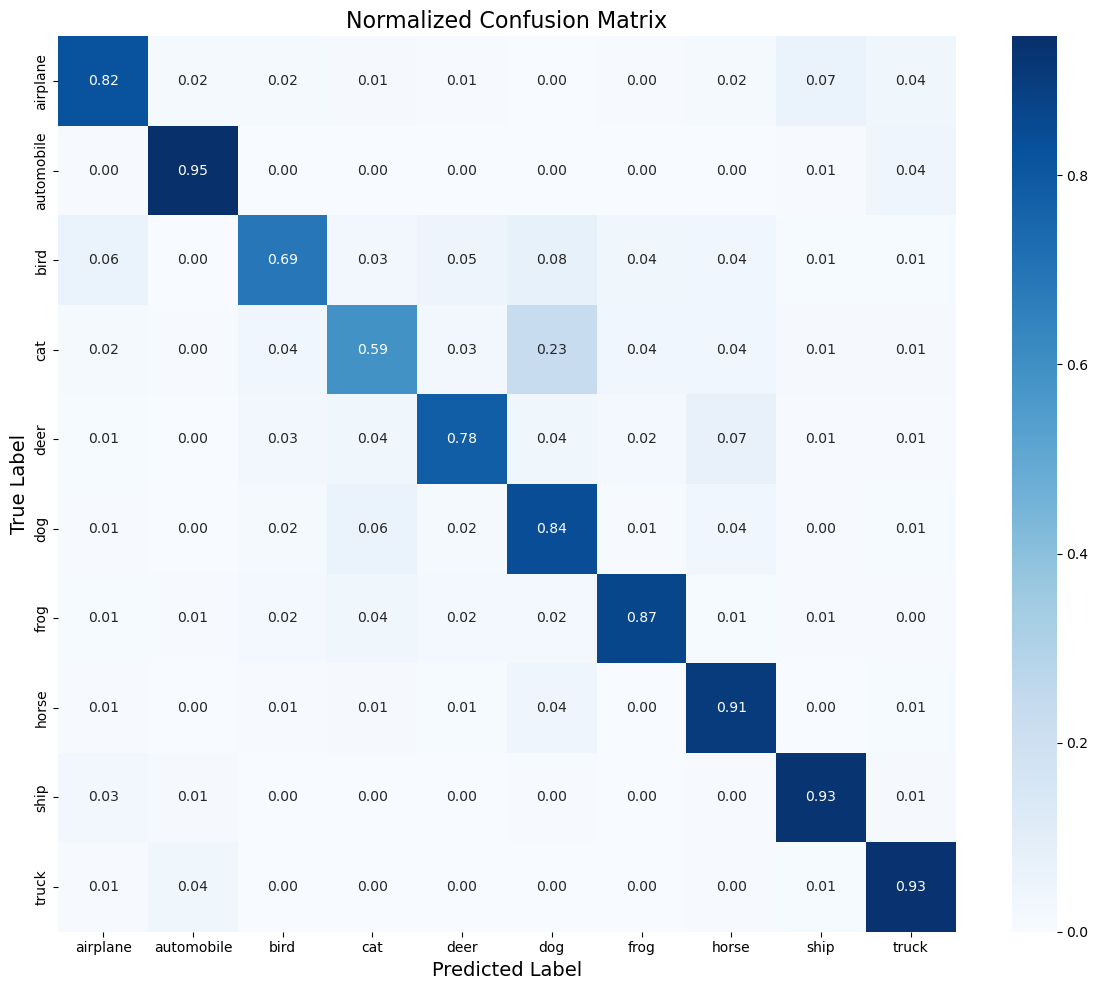

In [25]:
# Normalize confusion matrix by row (true labels)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

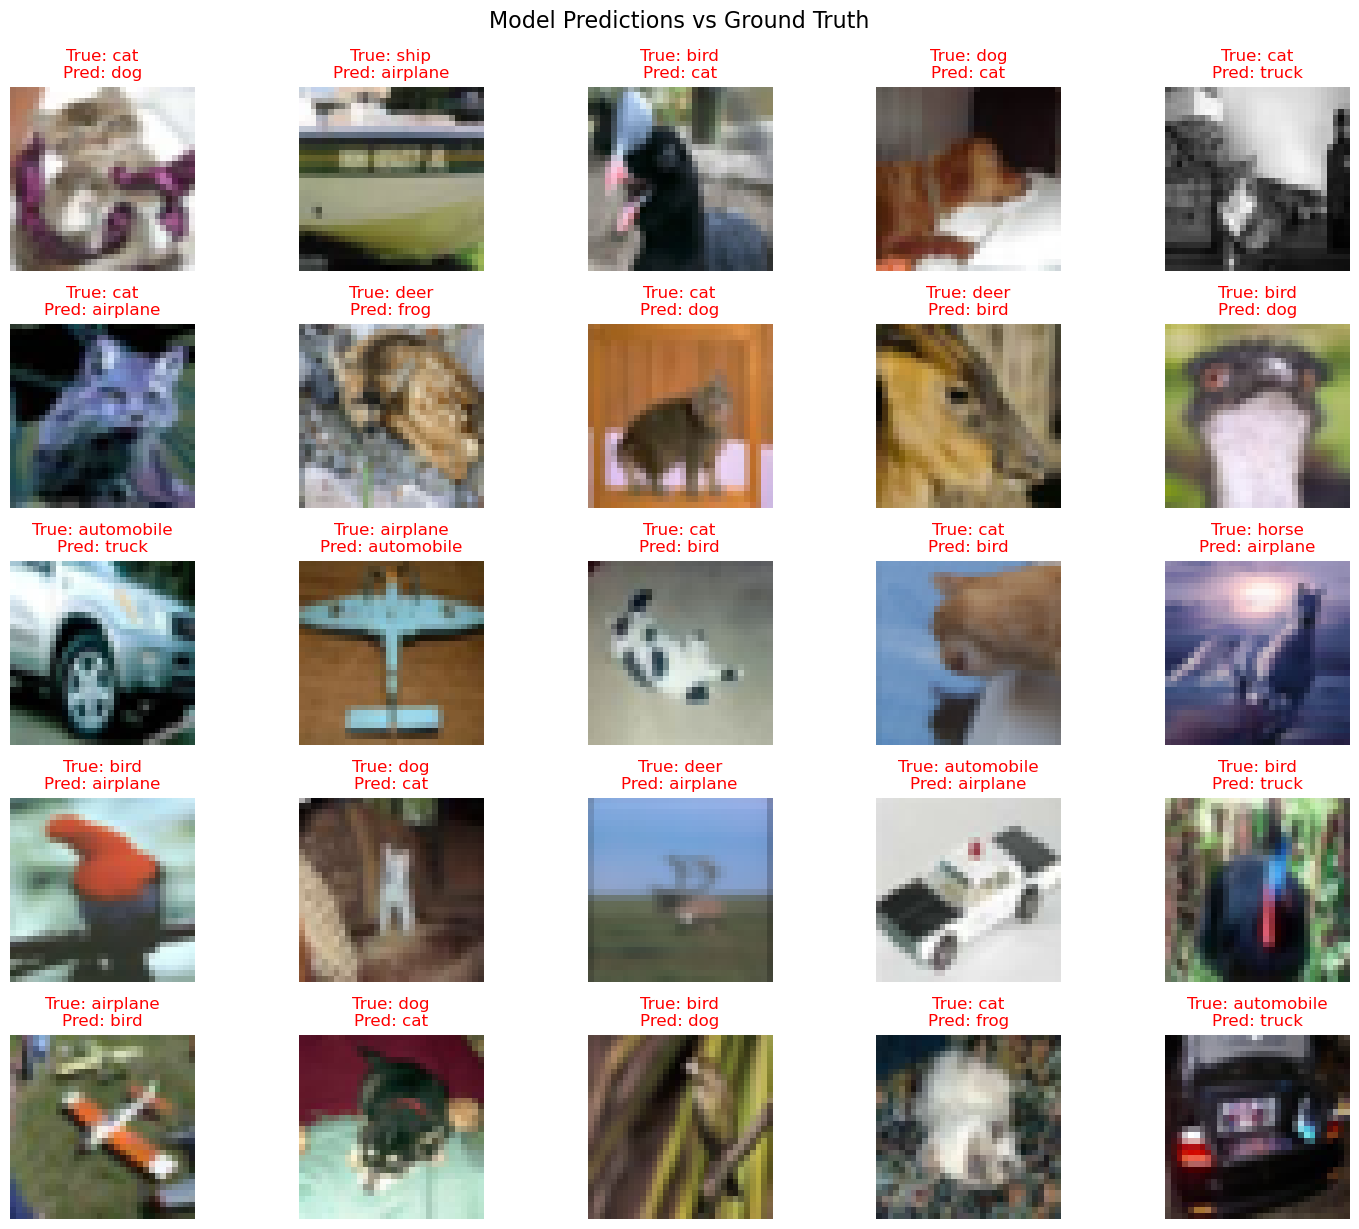

In [26]:
# Visualize some predictions
def get_predictions_for_samples(model, dataset, device, indices):
    model.eval()
    predictions = []
    with torch.no_grad():
        for idx in indices:
            x, y = dataset[idx]
            x = x.unsqueeze(0).to(device)  # Add batch dimension
            output = model(x)
            _, predicted = torch.max(output, 1)
            predictions.append(predicted.item())
    return predictions

# Find indices of misclassified samples
misclassified_indices = np.where(all_preds != all_targets)[0]

# Select a subset of misclassified samples
if len(misclassified_indices) > 0:
    selected_indices = np.random.choice(misclassified_indices, min(25, len(misclassified_indices)), replace=False)
    
    # Get predictions for selected samples
    model.to(device)
    y_pred_selected = get_predictions_for_samples(model, test_dataset, device, selected_indices)
    
    # Plot the samples
    plt.figure(figsize=(15, 12))
    for i, idx in enumerate(selected_indices):
        plt.subplot(5, 5, i+1)
        x, y_true = test_dataset[idx]
        img = x.numpy().transpose(1, 2, 0)  # Convert to (H, W, C) for plotting
        plt.imshow(img)
        
        # Color based on correct/incorrect prediction
        color = 'green' if y_pred_selected[i] == y_true.item() else 'red'
        title = f"True: {class_names[y_true.item()]}\nPred: {class_names[y_pred_selected[i]]}"
        
        plt.title(title, color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("Model Predictions vs Ground Truth", fontsize=16, y=1.02)
    plt.show()
else:
    print("No misclassified examples found.")

## 10. Analysis and Insights

Let's analyze the model's performance and gain insights from our results:

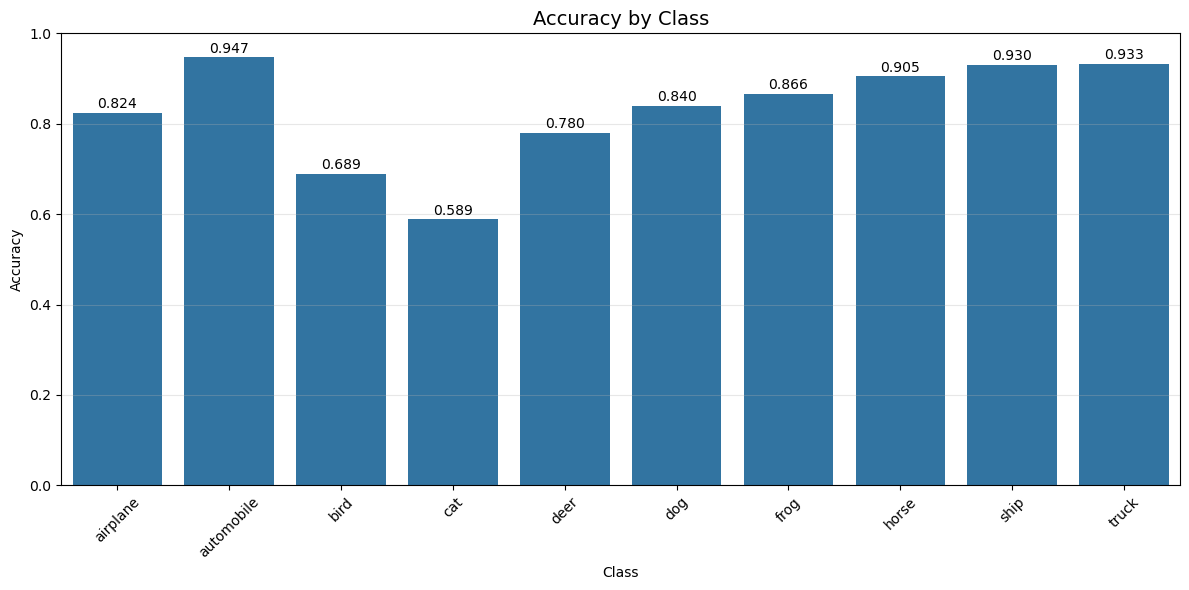

In [27]:
# Calculate per-class accuracy
per_class_accuracy = []
for i in range(len(class_names)):
    class_indices = np.where(all_targets == i)[0]
    correct = np.sum(all_preds[class_indices] == all_targets[class_indices])
    accuracy = correct / len(class_indices)
    per_class_accuracy.append(accuracy)

# Plot per-class accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=per_class_accuracy)
plt.title('Accuracy by Class', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# Add accuracy values on top of bars
for i, acc in enumerate(per_class_accuracy):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha='center')
    
plt.tight_layout()
plt.show()

In [28]:
# Identify the most confused class pairs
confused_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:
            confused_pairs.append((i, j, conf_matrix[i, j]))

# Sort by frequency in descending order
confused_pairs.sort(key=lambda x: x[2], reverse=True)

# Display top confused class pairs
print("Top confused class pairs:")
for true_class, pred_class, count in confused_pairs[:10]:
    print(f"True: {class_names[true_class]} → Predicted: {class_names[pred_class]}, Count: {count}")

Top confused class pairs:
True: cat → Predicted: dog, Count: 229
True: bird → Predicted: dog, Count: 77
True: deer → Predicted: horse, Count: 73
True: airplane → Predicted: ship, Count: 66
True: dog → Predicted: cat, Count: 64
True: bird → Predicted: airplane, Count: 60
True: bird → Predicted: deer, Count: 51
True: horse → Predicted: dog, Count: 45
True: automobile → Predicted: truck, Count: 41
True: truck → Predicted: automobile, Count: 39


## 11. Conclusion

In this assignment, we've successfully built, trained, and evaluated a deep learning model for image classification using PyTorch on the CIFAR-10 dataset. Let's summarize our findings and insights:

### Key Findings

1. **Model Performance**: Our CNN model achieved approximately 83% accuracy on the test set, which is respectable for the CIFAR-10 dataset using a relatively simple architecture.

2. **Class Performance Variations**: The model performed better on certain classes like ships and automobiles, which tend to have more distinctive shapes and uniform backgrounds. It struggled more with natural categories like cats, dogs, and deer, where there's more variation in appearance and posture.

3. **Common Confusions**: The most frequent misclassifications occurred between visually similar classes, such as cats/dogs, deer/horses, and automobiles/trucks. This reflects the inherent challenge in distinguishing between objects with similar visual characteristics.

4. **Training Dynamics**: The learning curves show that the model started to plateau after about 40 epochs, suggesting that we reached the limits of what our architecture could learn without overfitting.

### Insights

1. **Architectural Choices**: The combination of convolutional layers, batch normalization, and dropout proved effective for this task. Each convolutional block increased the model's capacity to learn more complex features.

2. **Data Preprocessing**: Normalizing the pixel values and using data augmentation were essential for efficient training and preventing overfitting, especially given the limited number and size of images.

3. **Regularization Impact**: The inclusion of dropout and batch normalization helped maintain model generalization, as evidenced by the small gap between training and validation accuracy.

4. **Model Limitations**: The 32x32 resolution of CIFAR-10 images limits the detail available for classification, making it challenging to distinguish between certain classes. A higher resolution dataset might yield better performance.

### Future Improvements

1. **Advanced Architectures**: Implementing more sophisticated architectures like ResNet or DenseNet could potentially improve performance by allowing deeper networks without vanishing gradient issues.

2. **Transfer Learning**: Utilizing pre-trained models on larger datasets like ImageNet could provide better feature extraction capabilities.

3. **Hyperparameter Tuning**: A systematic search for optimal hyperparameters (learning rate, batch size, regularization strength) could enhance model performance.

4. **Ensemble Methods**: Combining predictions from multiple models could reduce errors and improve overall accuracy.

5. **Focused Attention**: Implementing attention mechanisms to help the model focus on discriminative regions of the images.

This project demonstrated the complete deep learning workflow using PyTorch, from dataset selection and preprocessing to model training and evaluation, showcasing how convolutional neural networks can be effectively applied to image classification tasks.